# Gradient Boosting Classifier

---

__This Notebook__

- implement sklearn.ensemble.GradientBoostingClassifier

__Results__ 

- 



## Setup

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import confusion_matrix

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-02-07


## Load

In [2]:
# load target vector
raw_path = os.path.join("data","1_raw")
y_df = pd.read_csv(os.path.join(raw_path, 'y_train.csv'))
y_array = np.array(y_df.iloc[:,0].ravel())

y = y_array.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load matrix
proc_dir = os.path.join("data", "2_processed")
X_tfidf_svd800_spamcos = sp.load_npz(os.path.join(proc_dir, 'X_tfidf_svd800_spamcos.npz'))

## Helpful Functions


In [3]:
# train classifier and time it
def time_deco(func):
    def wrapper(clf):
        start = time.time()
        func(clf)
        m,s = divmod(time.time() - start, 60)
        print(f'Elapsed: {m:0.0f}m {s:0.0f}s')
    return wrapper

@time_deco
def fit_clf(clf):
    clf.fit(X_train, y_train)
    
# evaluate classifier
def eval_clf(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, 
                                      y_pred).ravel()
    confmat_df = pd.DataFrame(
        np.array(([tn, fp], [fn, tp])),
        columns=['pred_neg', 'pred_pos'], 
        index=['cond_neg', 'cond_pos']
    )
    # unpack metrics
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    # print results
    print(confmat_df)
    print(f'acc: {acc:0.4f}')
    print(f'tpr: {tpr:0.4f}')
    print(f'tnr: {tnr:0.4f}')

def extract_df(gd):
    gd_res = gd.cv_results_
    df = pd.concat([
                    pd.DataFrame(gd_res["params"]),
                    pd.DataFrame(gd_res["mean_train_acc"], columns=["mean_train_acc"]),
                    pd.DataFrame(gd_res["mean_train_tpr"], columns=["mean_train_tpr"]),
                    pd.DataFrame(gd_res["mean_train_tnr"], columns=["mean_train_tnr"]),
                    pd.DataFrame(gd_res["mean_test_acc"], columns=["mean_val_acc"]),
                    pd.DataFrame(gd_res["mean_test_tpr"], columns=["mean_val_tpr"]),
                    pd.DataFrame(gd_res["mean_test_tnr"], columns=["mean_val_tnr"]),
                    pd.DataFrame(gd_res["mean_fit_time"], columns=["mean_fit_time"]),
                    pd.DataFrame(gd_res["std_test_acc"], columns=["std_val_acc"]),
                    pd.DataFrame(gd_res["std_test_tpr"], columns=["std_val_tpr"]),
                    pd.DataFrame(gd_res["std_test_tnr"], columns=["std_val_tnr"]),
                   ]
                   , axis=1)
    return df

### Train Test Split

##  Gradient Boosting Classifier


```
class GradientBoostingClassifier(ClassifierMixin, BaseGradientBoosting):
    """Gradient Boosting for classification.
    GB builds an additive model in a
    forward stage-wise fashion; it allows for the optimization of
    arbitrary differentiable loss functions. In each stage ``n_classes_``
    regression trees are fit on the negative gradient of the
    binomial or multinomial deviance loss function. Binary classification
    is a special case where only a single regression tree is induced.
```

See [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), [code](https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_gb.py#L768)

__Some defaults:__


- `loss='deviance'`
- `learning_rate=0.1`
- `n_estimators=100`
- `subsample=1.0`
- `criterion='friedman_mse'`
- `min_samples_split=2`
- `min_samples_leaf=1`
- `min_weight_fraction_leaf=0.0`
- `max_depth=3`
- `min_impurity_decrease=0.0`
- `min_impurity_split=None`
- `init=None`
- `random_state=None`
- `max_features=None`
- `verbose=0`
- `max_leaf_nodes=None`
- `warm_start=False`
- `validation_fraction=0.1`
- `n_iter_no_change=None`
- `tol=0.0001`
- `ccp_alpha=0.0`

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_tfidf_svd800_spamcos,
                                                  y, 
                                                  stratify=y,
                                                  random_state=42)

In [8]:
gb_clf = GradientBoostingClassifier(
    random_state=42
    , verbose=1
)

In [9]:
gb_clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.5970           57.27s
         2           0.4986           56.15s
         3           0.4280           55.11s
         4           0.3728           54.46s
         5           0.3278           53.67s
         6           0.2902           52.85s
         7           0.2575           52.13s
         8           0.2298           51.49s
         9           0.2052           50.83s
        10           0.1842           50.21s
        20           0.0661           44.16s
        30           0.0261           38.49s
        40           0.0117           32.92s
        50           0.0063           27.39s
        60           0.0040           21.97s
        70           0.0031           16.46s
        80           0.0025           10.96s
        90           0.0021            5.48s
       100           0.0018            0.00s


GradientBoostingClassifier(random_state=42, verbose=1)

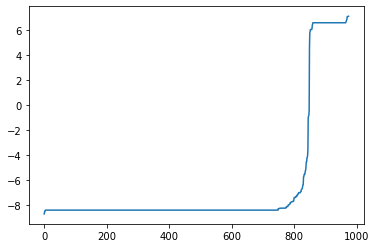

In [13]:
# evaluate using decision function
y_score = gb_clf.decision_function(X_val)
plt.plot(sorted(y_score))
plt.show()

In [14]:
# default threshold
thresh = 0
y_pred = np.where(y_score > thresh, 1, 0)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       844         2
cond_pos         5       124
acc: 0.9928
tpr: 0.9612
tnr: 0.9976


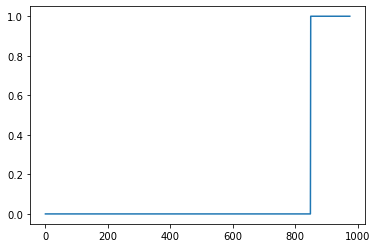

In [16]:
y_pred = gb_clf.predict(X_val)
plt.plot(sorted(y_pred))
plt.show()

In [17]:
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       844         2
cond_pos         5       124
acc: 0.9928
tpr: 0.9612
tnr: 0.9976


## GridSearchCV

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def gridsearch_wrapper(X, y, param_grid, k=5, n_jobs=6):
    """
    Performs a grid search with
    Args:
        X: numeric matrix
        y: target variable
        k: number of CV folds
        n_jobs: number of logical cores
    """
    start_time = time.time()

    # split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, 
                                                      y, 
                                                      stratify=y,
                                                      random_state=42)

    # setup scorers
    scorers = {
        'acc': make_scorer(accuracy_score),
        'tpr': make_scorer(recall_score, pos_label=1), # sensitivity, recall
        'tnr': make_scorer(recall_score, pos_label=0) # specificity, selectivity
    }

    # instantiate estimator
    clf =  GradientBoostingClassifier(
        random_state=42
    )

    # instantiate k-fold gridsearch
    cv_folds = StratifiedKFold(n_splits=k)
    
    grid_search_clf = GridSearchCV(clf, 
                                   param_grid,
                                   scoring=scorers, 
                                   refit='tpr', 
                                   cv=cv_folds, 
                                   return_train_score=True, 
                                   n_jobs=n_jobs,
                                   verbose=1)
    
    # train models
    grid_search_clf.fit(X_train, y_train)

    # predict
    y_pred = grid_search_clf.predict(X_val)
    print(f'Best params: {grid_search_clf.best_params_}')

    # eval metrics
    print('Evaluation metrics:')
    eval_clf(y_val, y_pred)
    
    return grid_search_clf

In [24]:
params = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [.001, .01]
}

In [26]:
gridsearch_clf1 = gridsearch_wrapper(X_tfidf_svd800_spamcos,
                                     y, 
                                     params,
                                     k=10,                        
                                     n_jobs=-1)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.7min finished


Best params: {'learning_rate': 0.01, 'n_estimators': 100}
Evaluation metrics:
          pred_neg  pred_pos
cond_neg       843         3
cond_pos         3       126
acc: 0.9938
tpr: 0.9767
tnr: 0.9965


In [27]:
df = extract_df(gridsearch_clf1)
df.sort_values(by=['mean_val_tpr'], ascending=False)

,learning_rate,n_estimators,mean_train_acc,mean_train_tpr,mean_train_tnr,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time,std_val_acc,std_val_tpr,std_val_tnr
5,0.010,100,0.997455,0.980815,1.0,0.993499,0.961404,0.998422,100.329280,0.004951,0.030935,0.001933
0,0.001,10,0.867350,0.000000,1.0,0.867351,0.000000,1.000000,9.362479,0.001271,0.000000,0.000000
1,0.001,50,0.867350,0.000000,1.0,0.867351,0.000000,1.000000,53.317426,0.001271,0.000000,0.000000
2,0.001,100,0.867350,0.000000,1.0,0.867351,0.000000,1.000000,108.201271,0.001271,0.000000,0.000000
3,0.010,10,0.867350,0.000000,1.0,0.867351,0.000000,1.000000,11.036705,0.001271,0.000000,0.000000
4,0.010,50,0.867502,0.001146,1.0,0.867351,0.000000,1.000000,54.453029,0.001271,0.000000,0.000000


In [15]:
df = extract_df(gridsearch_clf1)
df.sort_values(by=['mean_val_tpr'], ascending=False)

,learning_rate,n_estimators,mean_train_acc,mean_train_tpr,mean_train_tnr,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time,std_val_acc,std_val_tpr,std_val_tnr
0,0.001,10,0.994644,0.975659,0.997547,0.993157,0.969096,0.996849,4.802966,0.004055,0.025236,0.003858
1,0.001,50,0.994644,0.975659,0.997547,0.993157,0.969096,0.996849,37.895976,0.004055,0.025236,0.003858
2,0.001,100,0.994644,0.975659,0.997547,0.993157,0.969096,0.996849,74.574805,0.004055,0.025236,0.003858
3,0.010,10,0.994644,0.975659,0.997547,0.993157,0.969096,0.996849,8.171846,0.004055,0.025236,0.003858
4,0.010,50,0.994644,0.975659,0.997547,0.993157,0.969096,0.996849,39.862671,0.004055,0.025236,0.003858
5,0.010,100,0.994644,0.975659,0.997547,0.993157,0.969096,0.996849,76.285308,0.004055,0.025236,0.003858


### Deeper trees

In [18]:
gridsearch_clf2 = gridsearch_wrapper(X_tfidf_svd800_spamcos, 
                                     y, 
                                     params,
                                     k=10, 
                                     max_depth=5,
                                     n_jobs=-1)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.2min finished


Best params: {'learning_rate': 0.01, 'n_estimators': 10}
Evaluation metrics:
          pred_neg  pred_pos
cond_neg       839         7
cond_pos         3       126
acc: 0.9897
tpr: 0.9767
tnr: 0.9917


In [20]:
df = extract_df(gridsearch_clf2)
df.sort_values(by=['mean_val_tpr'], ascending=False)

,learning_rate,n_estimators,mean_train_acc,mean_train_tpr,mean_train_tnr,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time,std_val_acc,std_val_tpr,std_val_tnr
3,0.010,10,1.000000,1.000000,1.0,0.989399,0.969096,0.992510,9.844403,0.005815,0.025236,0.005699
4,0.010,50,1.000000,1.000000,1.0,0.989399,0.969096,0.992510,29.583053,0.005815,0.025236,0.005699
5,0.010,100,1.000000,1.000000,1.0,0.989399,0.969096,0.992510,40.069161,0.005815,0.025236,0.005699
0,0.001,10,0.999506,0.996275,1.0,0.988716,0.963968,0.992512,17.247713,0.005731,0.026231,0.006700
1,0.001,50,0.999658,0.997421,1.0,0.988716,0.963968,0.992512,54.347530,0.005731,0.026231,0.006700
2,0.001,100,0.999658,0.997421,1.0,0.988716,0.963968,0.992512,81.525042,0.005731,0.026231,0.006700


In [27]:
gridsearch_clf3 = gridsearch_wrapper(X_tfidf_svd800_spamcos, 
                                     y, 
                                     {'n_estimators': [5, 10, 20],
                                      'learning_rate': [.001, .01, .1, 1]},
                                     k=10, 
                                     max_depth=2,
                                     n_jobs=-1)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.8min finished


Best params: {'learning_rate': 0.1, 'n_estimators': 20}
Evaluation metrics:
          pred_neg  pred_pos
cond_neg       843         3
cond_pos         2       127
acc: 0.9949
tpr: 0.9845
tnr: 0.9965


In [28]:
df = extract_df(gridsearch_clf3)
df.sort_values(by=['mean_val_tpr'], ascending=False)

,learning_rate,n_estimators,mean_train_acc,mean_train_tpr,mean_train_tnr,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time,std_val_acc,std_val_tpr,std_val_tnr
8,0.100,20,0.998974,0.992269,1.000000,0.994183,0.969163,0.998030,17.887918,0.003445,0.022339,0.003631
1,0.001,10,0.995783,0.976518,0.998730,0.992133,0.966532,0.996061,7.444222,0.004342,0.030529,0.005282
2,0.001,20,0.995783,0.976518,0.998730,0.992133,0.966532,0.996061,16.940128,0.004342,0.030529,0.005282
3,0.010,5,0.995859,0.975945,0.998905,0.992815,0.966532,0.996849,4.642983,0.003892,0.030529,0.003858
4,0.010,10,0.996125,0.976518,0.999124,0.992474,0.966532,0.996455,9.401912,0.003994,0.030529,0.004472
5,0.010,20,0.996201,0.976232,0.999255,0.992815,0.966532,0.996849,18.485027,0.003892,0.030529,0.003858
6,0.100,5,0.996125,0.975086,0.999343,0.992815,0.966532,0.996849,5.553625,0.003892,0.030529,0.003858
7,0.100,10,0.996733,0.977949,0.999606,0.993498,0.966532,0.997636,10.071650,0.004453,0.030529,0.003609
0,0.001,5,0.995707,0.975660,0.998774,0.992134,0.963968,0.996455,3.865002,0.004062,0.030839,0.004806
10,1.000,10,1.000000,1.000000,1.000000,0.992473,0.963900,0.996846,8.946135,0.004280,0.031044,0.002364


In [30]:
# persist
save_path = os.path.join("data", "3_modeling", "02072021_ada_gridsearch3.joblib")
joblib.dump(gridsearch_clf3, save_path)

['data\\3_modeling\\02072021_ada_gridsearch3.joblib']

In [34]:
gridsearch_clf4 = gridsearch_wrapper(X_tfidf_svd800_spamcos, 
                                     y, 
                                     {'n_estimators': [10, 20],
                                      'learning_rate': [.001, .01, .1]},
                                     k=10, 
                                     min_samples_split=5,
                                     n_jobs=-1)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   58.0s finished


Best params: {'learning_rate': 0.001, 'n_estimators': 10}
Evaluation metrics:
          pred_neg  pred_pos
cond_neg       839         7
cond_pos         2       127
acc: 0.9908
tpr: 0.9845
tnr: 0.9917


In [35]:
df = extract_df(gridsearch_clf3)
df.sort_values(by=['mean_val_tpr'], ascending=False)

,learning_rate,n_estimators,mean_train_acc,mean_train_tpr,mean_train_tnr,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time,std_val_acc,std_val_tpr,std_val_tnr
8,0.100,20,0.998974,0.992269,1.000000,0.994183,0.969163,0.998030,17.887918,0.003445,0.022339,0.003631
1,0.001,10,0.995783,0.976518,0.998730,0.992133,0.966532,0.996061,7.444222,0.004342,0.030529,0.005282
2,0.001,20,0.995783,0.976518,0.998730,0.992133,0.966532,0.996061,16.940128,0.004342,0.030529,0.005282
3,0.010,5,0.995859,0.975945,0.998905,0.992815,0.966532,0.996849,4.642983,0.003892,0.030529,0.003858
4,0.010,10,0.996125,0.976518,0.999124,0.992474,0.966532,0.996455,9.401912,0.003994,0.030529,0.004472
5,0.010,20,0.996201,0.976232,0.999255,0.992815,0.966532,0.996849,18.485027,0.003892,0.030529,0.003858
6,0.100,5,0.996125,0.975086,0.999343,0.992815,0.966532,0.996849,5.553625,0.003892,0.030529,0.003858
7,0.100,10,0.996733,0.977949,0.999606,0.993498,0.966532,0.997636,10.071650,0.004453,0.030529,0.003609
0,0.001,5,0.995707,0.975660,0.998774,0.992134,0.963968,0.996455,3.865002,0.004062,0.030839,0.004806
10,1.000,10,1.000000,1.000000,1.000000,0.992473,0.963900,0.996846,8.946135,0.004280,0.031044,0.002364


---